I used this notebook to figure out how to sample the PBH's radial coordinate $r$ within a given range $[r_{\mathrm{min}}, r_{\mathrm{max}}]$.
* Currently I just resample any $r$ values outside this range. This is obviously not very efficient, though.
* I also looked into modifying the algorithm for drawing from the $\Gamma$ distribution to only generate values within the specified range. It is not totally clear how to do this. I suspect a modified version of the Ahrens-Dieter acceptance-rejection method would work.

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.special import gammainc, gamma

from numba import jit

In [2]:
alpha_mw = 0.17
r_s_mw = 28.44  # kpc

def sample_dists(n):
    return np.random.gamma(shape=3/alpha_mw,
                           scale=alpha_mw*r_s_mw**alpha_mw/2,
                           size=n)**(1/alpha_mw)

# Naive rejection method

In [49]:
n_samples = 100000
dists = sample_dists(n_samples)
d_ms = 3 * np.ones(n_samples)
d_earth = 8.33
truncate_radial_samples = True

if truncate_radial_samples:
    while True:
        idxs_oob = (dists > d_earth + d_ms) | (dists < d_earth - d_ms)
        n_oob = np.sum(idxs_oob)
        if n_oob == 0:
            break
        else:
            dists[idxs_oob] = sample_dists(n_oob)

In [41]:
from scipy.integrate import quad

def _r_dist_pdf_unnormed(r):
    return r**2 * np.exp(-2/alpha_mw * (r/r_s_mw)**alpha_mw)

r_dist_pdf_norm_const = quad(_r_dist_pdf_unnormed, 0, np.inf)[0]

def r_dist_pdf(r):
    return r**2 * np.exp(-2/alpha_mw * (r/r_s_mw)**alpha_mw) / r_dist_pdf_norm_const

def r_dist_cdf(r):
    return gammainc(3/alpha_mw, 2/alpha_mw*(r/r_s_mw)**alpha_mw)

Testing CDF and samples

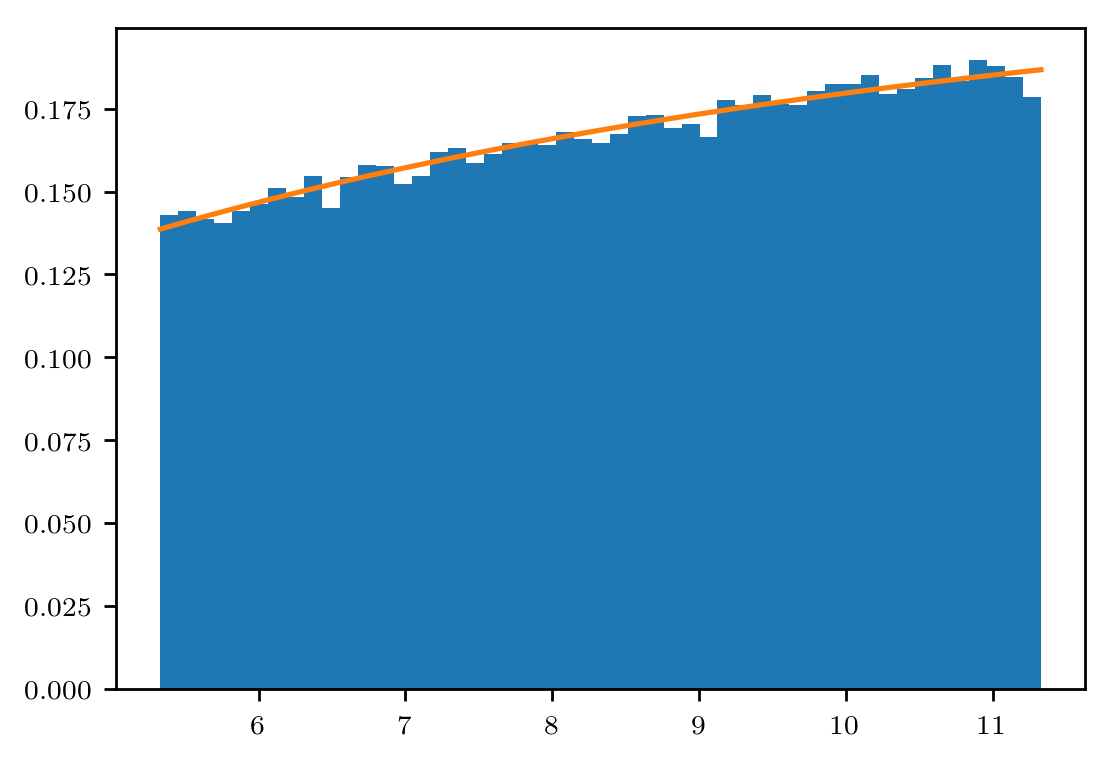

In [55]:
plt.hist(dists, density=True,
         bins=np.linspace(np.max([0, d_earth - d_ms[0]]), d_earth + d_ms[0]))

rs = np.linspace(np.max([0, d_earth - d_ms[0]]), d_earth + d_ms[0], 500)
plt.plot(rs, r_dist_pdf(rs) / (r_dist_cdf(d_earth + d_ms[0]) -
                               r_dist_cdf(np.max([0, d_earth - d_ms[0]]))))

# Modifying the sampler

In [27]:
def gamma_samples(shape, size=1):
    samples = []
    for i in range(size):
        while True:
            u = np.random.uniform()  # pretty sure this is right...
            v = np.random.standard_exponential()
            if u <= 1 - shape:
                x = u**(1/shape)
                if x <= v:
                    samples.append(x)
                    break
            else:
                y = -np.log((1 - u) / shape)
                x = (1 - shape + shape * y)**(1/shape)
                if x <= v + y:
                    samples.append(x)
                    break
    return samples

def gamma_pdf(x, shape=1, scale=1):
    return x**(shape-1) * np.exp(-x / scale) / scale**shape / gamma(shape)

def gamma_cdf(x, shape=1, scale=1):
    return gammainc(shape, x / scale)

In [52]:
def gamma_tr_sample(x_min, x_max, shape=1, scale=1, size=1):
    """Use inverse CDF sampling to sample from a truncated gamma distribution.
    """
    cdf_min = gamma_cdf(x_min, shape, scale)
    cdf_max = gamma_cdf(x_max, shape, scale)
    
    u = stats.gamma(a=shape, loc=0, scale=scale).ppf(
        cdf_min + np.random.uniform(size=size) * (cdf_max - cdf_min))
    
    return u

In [54]:
gamma_tr_sample(np.array([2, 3, 2.3]), np.array([10, 12, 11.9]))

array([2.70727276, 3.70749094, 3.00754824])

In [47]:
%%timeit
np.random.gamma(shape=1, scale=1)

2.23 µs ± 10.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in power


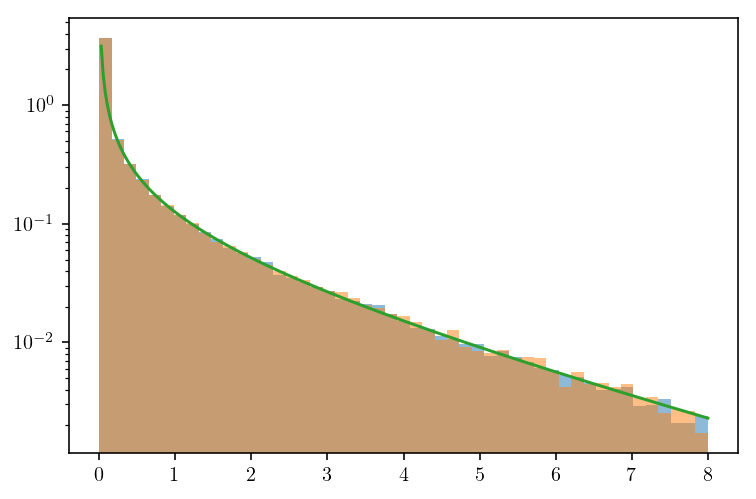

In [51]:
shape = 0.2
scale = 3

bins = np.linspace(0, 8)
plt.hist(np.random.gamma(shape=shape, scale=scale, size=100000),
         bins=bins, density=True, alpha=0.5)
plt.hist(gamma_tr_sample(0, 100, shape=shape, scale=scale, size=100000),
         bins=bins, alpha=0.5, density=True)

xs = np.linspace(bins[0], bins[-1], 300)
plt.plot(xs, gamma_pdf(xs, shape=shape, scale=scale))

plt.yscale("log")